# 2. System Matrices Evaluation and Control Input Derivation

In [1]:
import gym
import numpy as np
import tensorflow as tf
import pickle
import os
from os import path

## Import matrices for linear control systems

In [2]:
model = tf.keras.models.load_model(
    './cartpole_system_model', custom_objects=None, compile=True, options=None
)

2022-04-06 15:04:02.880407: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
np_weights = model.get_weights()
print(model.A.get_weights())
print(model.B.get_weights())

[array([[ 1.0000000e+00,  2.8594382e-04, -4.5564782e-08,  8.6408173e-04],
       [ 2.0000003e-02,  9.9994367e-01,  2.9265443e-08, -7.2883966e-04],
       [-3.1767406e-08, -1.3775987e-02,  1.0000000e+00,  3.1655234e-01],
       [-3.4968859e-09,  2.1930250e-04,  2.0000009e-02,  9.9978548e-01]],
      dtype=float32)]
[array([[-1.4053483e-09,  1.9509907e-01, -1.3254321e-08, -2.9150683e-01]],
      dtype=float32)]


In [4]:
A = np_weights[0]
B = np_weights[1].T
print("A Matrix")
print(A)
print("B Matrix")
print(B)

A Matrix
[[ 1.0000000e+00  2.8594382e-04 -4.5564782e-08  8.6408173e-04]
 [ 2.0000003e-02  9.9994367e-01  2.9265443e-08 -7.2883966e-04]
 [-3.1767406e-08 -1.3775987e-02  1.0000000e+00  3.1655234e-01]
 [-3.4968859e-09  2.1930250e-04  2.0000009e-02  9.9978548e-01]]
B Matrix
[[-1.4053483e-09]
 [ 1.9509907e-01]
 [-1.3254321e-08]
 [-2.9150683e-01]]


## Deriving K

Rewrite the control system equation using $u = - Kx$.

$$
\begin{align}
    \dot x &= Ax - Bu \\
    \dot x &= Ax - BKx \\
\end{align}
$$

Define the target control system with the desired eigenvalue and eigenvector placements as $\dot x = Tx$.

Derive the state space to control input transformation $K$.

$$
\begin{align}
    \dot x 
        &= Tx \\
        &= Ax - BKx \\
    Tx &= Ax - BKx \\
    T &= A - BK \\
    K &= - B^{-1}_{left} (T - A) \\
\end{align}
$$

where $B^{-1}_{left}$ is the left inverse of $B$, which can be derived as,

$$
\begin{align}
    (A^T A)^{-1} A^T A &= I \\
    (A^T A)^{-1} A^T &= A^{-1}_{left} \\
\end{align}
$$

since $A^{-1}_{left} A = I$.

In [5]:
L, V = np.linalg.eig(A)
print("Eigenvalues")
print(L)
print("Eigenvectors")
print(V)

Eigenvalues
[0.9203467 0.9974113 1.0025    1.0794711]
Eigenvectors
[[-0.0026594  -0.12393044  0.12821224  0.0026406 ]
 [ 0.00290405  0.9912179   0.990798   -0.00156652]
 [-0.9697325  -0.01600512 -0.0050172   0.9699134 ]
 [ 0.2441379   0.04326752  0.04307875  0.24343067]]


In [6]:
# Define desirable T = A - BK (test)
T = np.diag((0, -1, -4, -2))

# calculate K
B_left_inv = np.matmul(np.linalg.inv(np.matmul(B.T, B)), B.T)
K = - np.matmul(B_left_inv, (T - A))
print("K Matrix")
print(K)

K Matrix
[[ 0.03171315  3.17070559 -0.04738463 -7.10826534]]


In [7]:
save_controller_dict = {"K": K, "Target": T, "A": A, "B": B}
print(save_controller_dict)
with open('./cartpole_system_model/controller.pkl', 'wb') as filepath:
    pickle.dump(save_controller_dict, filepath, protocol=pickle.HIGHEST_PROTOCOL)

{'K': array([[ 0.03171315,  3.17070559, -0.04738463, -7.10826534]]), 'Target': array([[ 0,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0, -4,  0],
       [ 0,  0,  0, -2]]), 'A': array([[ 1.0000000e+00,  2.8594382e-04, -4.5564782e-08,  8.6408173e-04],
       [ 2.0000003e-02,  9.9994367e-01,  2.9265443e-08, -7.2883966e-04],
       [-3.1767406e-08, -1.3775987e-02,  1.0000000e+00,  3.1655234e-01],
       [-3.4968859e-09,  2.1930250e-04,  2.0000009e-02,  9.9978548e-01]],
      dtype=float32), 'B': array([[-1.4053483e-09],
       [ 1.9509907e-01],
       [-1.3254321e-08],
       [-2.9150683e-01]], dtype=float32)}


## Testing

In [8]:
with open('./cartpole_system_model/controller.pkl', 'rb') as filepath:
    controller_dict = pickle.load(filepath)
K = controller_dict['K']

Plug in $u = -Kx$

In [9]:
env = gym.make('CartPole-v0')
x = env.reset()
cumul_reward = 0
for _ in range(1000):
    u = np.matmul(-K, x)
    if u < 0:
        u = 0
    else:
        u = 1
    x, reward, done, _ = env.step(u)
    cumul_reward += reward
    if done:
        break
env.close()
print(cumul_reward)

62.0


## Optimizing T

In [10]:
import cma

In [11]:
# A, B, and B_left_inv matrices are global
def cartpole_loss(target_matrix):
    # row-major target matrix to T
    selected_T = tf.reshape(target_matrix, [4, 4])
    
    # compute K given T
    selected_K = - np.matmul(B_left_inv, selected_T - A)
    
    # cartpole simulation
    env = gym.make('CartPole-v1')
    x = env.reset()
    cumul_reward = 500
    for _ in range(500):
        u = np.matmul(-selected_K, x)
        if u < 0:
            u = 0
        else:
            u = 1
        x, reward, done, _ = env.step(u)
        cumul_reward -= reward
        if done:
            break
    env.close()
    return cumul_reward

In [12]:
init_T = np.reshape(np.diag((0, -1, -4, -2)), [16, ])
es = cma.CMAEvolutionStrategy(init_T, 1.0)
with open('./cartpole_system_model/cma_es_history.pkl', 'wb') as filepath:
    pickle.dump(es, filepath)

while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [cartpole_loss(x) for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()
with open('./cartpole_system_model/cma_es_history.pkl', 'wb') as filepath:
    pickle.dump(es, filepath)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 16 (seed=380322, Wed Apr  6 15:04:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.550000000000000e+02 1.0e+00 9.36e-01  9e-01  9e-01 0:00.0
    2     24 0.000000000000000e+00 1.1e+00 9.47e-01  9e-01  1e+00 0:00.1
    3     36 0.000000000000000e+00 1.2e+00 9.70e-01  9e-01  1e+00 0:00.2
   23    276 0.000000000000000e+00 1.8e+00 5.83e-01  5e-01  6e-01 0:01.9


termination on tolflatfitness=1
final/bestever f-value = 0.000000e+00 0.000000e+00
incumbent solution: [ 0.41463077 -3.65884892 -2.9838534   1.07602448 -1.18325511  1.98160661
 -0.12837819 -1.35484737 ...]
std deviations: [0.53073543 0.58769645 0.58191235 0.57573904 0.57477192 0.57500466
 0.56746968 0.57136718 ...]


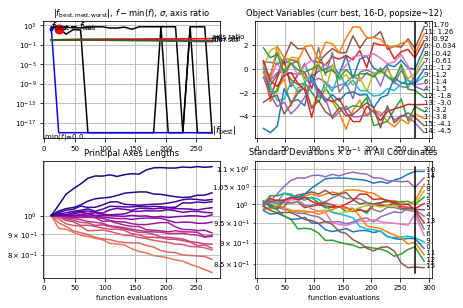

In [13]:
es.result_pretty()
cma.plot()  # shortcut for es.logger.plot()

In [14]:
with open('./cartpole_system_model/cma_es_history.pkl', 'rb') as filepath:
    es = pickle.load(filepath)
print(es)

In [15]:
dir(es)

['B',
 'C',
 'D',
 'N',
 'N_pheno',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_copy_light',
 '_flgtelldone',
 '_force_final_logging',
 '_injected_solutions_archive',
 '_prepare_callback_list',
 '_prepare_injection_directions',
 '_random_rescaling_factor_to_mahalanobis_size',
 '_record_rankings',
 '_record_rankings_',
 '_set_x0',
 '_stopdict',
 '_tfg',
 '_tfp',
 '_updateBDfromSM',
 'adapt_sigma',
 'alleviate_conditioning',
 'alleviate_conditioning_in_coordinates',
 'archive',
 'ary',
 'ask',
 'ask_and_eval',
 'ask_geno',
 'best',
 'boundary_handler',
 'callbackstop',
 'condition_number',
 'const',
 'count_eigen',
 'countevals',
 'countiter',
 'd

In [16]:
print(es.result.xbest)
print(es.result.fbest)

[-0.53207052 -2.76832765 -1.94057818 -2.48352025 -0.96955896 -1.39163115
 -0.93393162  0.55278932  1.54366069 -1.45166408 -5.37317168 -0.86475311
  0.92364931 -1.01747702 -2.20952405 -2.41763709]
0.0


In [18]:
best_T = np.reshape(es.result.xbest, [4, 4])
best_K = - np.matmul(B_left_inv, best_T - A)

save_best_controller_dict = {"K": best_K, "Target": best_T, "A": A, "B": B}
print(save_best_controller_dict)
with open('./cartpole_system_model/best_controller.pkl', 'wb') as filepath:
    pickle.dump(save_best_controller_dict, filepath, protocol=pickle.HIGHEST_PROTOCOL)

{'K': array([[ 3.75741695,  1.38108557, -3.80130691, -8.97426814]]), 'Target': array([[-0.53207052, -2.76832765, -1.94057818, -2.48352025],
       [-0.96955896, -1.39163115, -0.93393162,  0.55278932],
       [ 1.54366069, -1.45166408, -5.37317168, -0.86475311],
       [ 0.92364931, -1.01747702, -2.20952405, -2.41763709]]), 'A': array([[ 1.0000000e+00,  2.8594382e-04, -4.5564782e-08,  8.6408173e-04],
       [ 2.0000003e-02,  9.9994367e-01,  2.9265443e-08, -7.2883966e-04],
       [-3.1767406e-08, -1.3775987e-02,  1.0000000e+00,  3.1655234e-01],
       [-3.4968859e-09,  2.1930250e-04,  2.0000009e-02,  9.9978548e-01]],
      dtype=float32), 'B': array([[-1.4053483e-09],
       [ 1.9509907e-01],
       [-1.3254321e-08],
       [-2.9150683e-01]], dtype=float32)}
